# Implementing instance segmentation using Mask R-CNN

The strategy that we'll adopt is as follows:

1. Fetch the dataset and then create datasets and dataloaders from it.

2. Create a ground truth in a format needed for PyTorch's official
implementation of Mask R-CNN.

3. Download the pre-trained Faster R-CNN model and attach a Mask R-CNN
head to it.

4. Train the model with a PyTorch code snippet that has been standardized
for training Mask R-CNN.

5. Infer on an image by performing non-max suppression first and then
identifying the bounding box and the mask corresponding to the people in
the image.



In [1]:
%wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/images.tar
%wget --quiet http://sceneparsing.csail.mit.edu/data/ChallengeData2017/annotations_instance.tar
%tar -xf images.tar
%tar -xf annotations_instance.tar
%rm images.tar annotations_instance.tar
%pip install -qU torch_snippets
%wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/engine.py
%wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/utils.py
%wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/transforms.py
%wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_eval.py
%wget --quiet https://raw.githubusercontent.com/pytorch/vision/release/0.12/references/detection/coco_utils.py
%pip install -q -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [1]:
from torch_snippets import *
from torch_snippets.inspector import inspect
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

from engine import train_one_epoch, evaluate
import utils
import transforms as T
device = 'cuda' if torch.cuda.is_available() else 'cpu'

/home/lacie/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
all_images = Glob('images/training')
all_annots = Glob('annotations_instance/training')

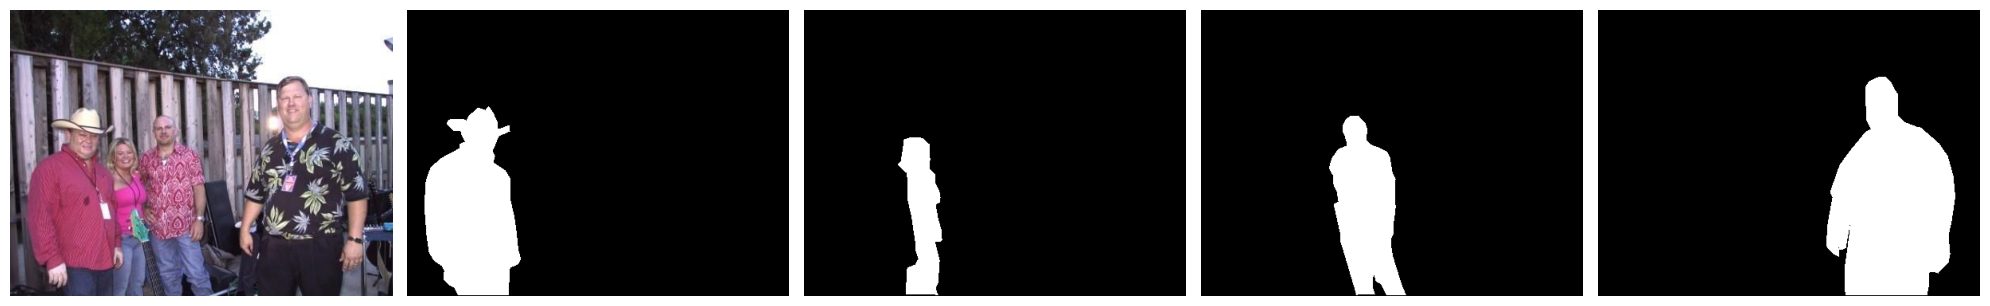

In [3]:
f = 'ADE_train_00014301'

im = read(find(f, all_images), 1)
an = read(find(f, all_annots), 1).transpose(2,0,1)
r,g,b = an
nzs = np.nonzero(r==4) # 4 stands for person
instances = np.unique(g[nzs])
masks = np.zeros((len(instances), *r.shape))
for ix,_id in enumerate(instances):
    masks[ix] = g==_id

subplots([im, *masks], sz=20)

In [4]:
annots = []
for ann in Tqdm(all_annots[:5000]):
    _ann = read(ann, 1).transpose(2,0,1)
    r,g,b = _ann
    if 4 not in np.unique(r): continue
    annots.append(ann)

100%|██████████| 5000/5000 [00:10<00:00, 474.87it/s]


In [5]:
from sklearn.model_selection import train_test_split
_annots = stems(annots)
trn_items, val_items = train_test_split(_annots, random_state=2)

In [6]:
def get_transform(train):
    image_transforms = []
    image_transforms.append(T.PILToTensor())
    if train:
        image_transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(image_transforms)

In [7]:
class MasksDataset(Dataset):
    def __init__(self, items, transforms, N):
        self.items = items
        self.transforms = transforms
        self.N = N
    def get_mask(self, path):
        an = read(path, 1).transpose(2,0,1)
        r,g,b = an
        nzs = np.nonzero(r==4)
        instances = np.unique(g[nzs])
        masks = np.zeros((len(instances), *r.shape))
        for ix,_id in enumerate(instances):
            masks[ix] = g==_id
        return masks
    def __getitem__(self, ix):
        _id = self.items[ix]
        img_path = f'images/training/{_id}.jpg'
        mask_path = f'annotations_instance/training/{_id}.png'
        masks = self.get_mask(mask_path)
        obj_ids = np.arange(1, len(masks)+1)
        img = Image.open(img_path).convert("RGB")
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            obj_pixels = np.where(masks[i])
            xmin = np.min(obj_pixels[1])
            xmax = np.max(obj_pixels[1])
            ymin = np.min(obj_pixels[0])
            ymax = np.max(obj_pixels[0])
            if (((xmax-xmin)<=10) | (ymax-ymin)<=10):
                xmax = xmin+10
                ymax = ymin+10
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        image_id = torch.tensor([ix])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        if (img.dtype == torch.float32) or (img.dtype == torch.uint8) :
          img = img/255.
        return img, target
    def __len__(self):
        return self.N
    def choose(self):
        return self[randint(len(self))]

══════════════════════════════════════════════════════════════════

tensor([[[0.9882, 0.9725, 0.9922,  ..., 0.3137, 0.4039, 0.4275],
         [0.9922, 0.9647, 0.9843,  ..., 0.4000, 0.5216, 0.4706],
         [0.9961, 0.9608, 0.9765,  ..., 0.6118, 0.4941, 0.2824],
         ...,
         [0.5333, 0.5059, 0.5333,  ..., 0.3765, 0.3765, 0.3882],
         [0.5333, 0.4902, 0.5255,  ..., 0.4667, 0.4745, 0.4902],
         [0.4667, 0.4392, 0.5098,  ..., 0.4510, 0.4902, 0.5333]],

        [[1.0000, 0.9843, 1.0000,  ..., 0.4000, 0.4902, 0.5137],
         [1.0000, 0.9765, 0.9961,  ..., 0.4902, 0.6118, 0.5608],
         [1.0000, 0.9686, 0.9843,  ..., 0.7059, 0.5882, 0.3765],
         ...,
         [0.4314, 0.4039, 0.4235,  ..., 0.4196, 0.4196, 0.4314],
         [0.4314, 0.3882, 0.4157,  ..., 0.5020, 0.5098, 0.5255],
         [0.3647, 0.3373, 0.4000,  ..., 0.4863, 0.5255, 0.5686]],

        [[0.9647, 0.9490, 0.9765,  ..., 0.2196, 0.3098, 0.3333],
         [0.9765, 0.9490, 0.9686,  ..., 0.3255, 0.4471, 0.3961],
         [0.9843, 0.9490, 0.9647,  ..., 0.5804, 0.4627, 0.2510],
         ...,
         [0.3333, 0.3059, 0.3294,  ..., 0.1843, 0.1843, 0.1961],
         [0.3333, 0.2902, 0.3216,  ..., 0.2863, 0.2941, 0.3098],
         [0.2667, 0.2392, 0.3059,  ..., 0.2784, 0.3176, 0.3608]]])

══════════════════════════════════════════════════════════════════

dict of 6 items

tensor([[456., 272., 493., 344.],
        [181., 276., 191., 286.],
        [189., 275., 199., 285.],
        [196., 276., 206., 286.],
        [230., 273., 233., 286.]])

tensor([1, 1, 1, 1, 1])

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)

tensor([0])

tensor([2664.,  100.,  100.,  100.,   39.])

... ... 1 more item(s)

══════════════════════════════════════════════════════════════════

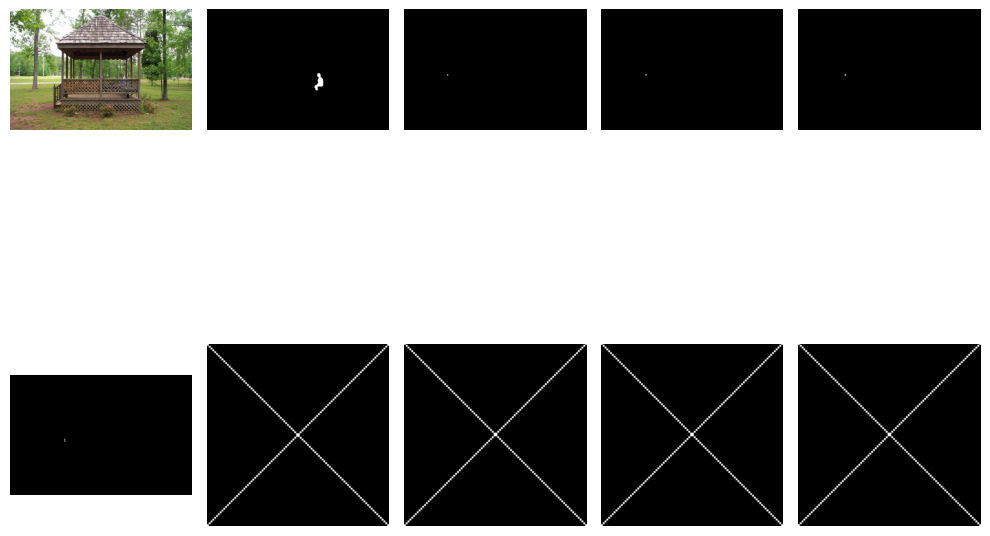

In [8]:
x = MasksDataset(trn_items, get_transform(train=True), N=100)
im,targ = x[0]
inspect(im,targ)
subplots([im, *targ['masks']], sz=10)

In [9]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,num_classes)
    return model

In [10]:
model = get_model_instance_segmentation(2).to(device)
model

/home/lacie/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/lacie/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [13]:
%pip install graphviz
%pip install torchview
from torchview import draw_graph

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 536.9 kB/s eta 0:00:00 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [14]:
model_graph = draw_graph(model)

RuntimeError: Only one of (input_data, input_size) should be specified.

In [11]:
dataset = MasksDataset(trn_items, get_transform(train=True), N=len(trn_items))
dataset_test = MasksDataset(val_items, get_transform(train=False), N=len(val_items))

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=1, shuffle=True, num_workers=0,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

In [12]:
num_classes = 2
model = get_model_instance_segmentation(num_classes).to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [13]:
num_epochs = 1

trn_history = []
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    res = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    trn_history.append(res)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset 
    res = evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/933]  eta: 0:24:27  lr: 0.000010  loss: 4.4644 (4.4644)  loss_classifier: 0.6201 (0.6201)  loss_box_reg: 1.0183 (1.0183)  loss_mask: 2.5156 (2.5156)  loss_objectness: 0.2665 (0.2665)  loss_rpn_box_reg: 0.0438 (0.0438)  time: 1.5732  data: 0.0069  max mem: 1251
Epoch: [0]  [ 10/933]  eta: 0:05:11  lr: 0.000064  loss: 3.4924 (3.7672)  loss_classifier: 0.5121 (0.5186)  loss_box_reg: 0.2735 (0.4367)  loss_mask: 2.5751 (2.7201)  loss_objectness: 0.0274 (0.0586)  loss_rpn_box_reg: 0.0151 (0.0332)  time: 0.3380  data: 0.0127  max mem: 1752
Epoch: [0]  [ 20/933]  eta: 0:04:18  lr: 0.000118  loss: 2.6600 (2.8158)  loss_classifier: 0.4502 (0.4523)  loss_box_reg: 0.3274 (0.4443)  loss_mask: 1.9184 (1.8534)  loss_objectness: 0.0141 (0.0428)  loss_rpn_box_reg: 0.0121 (0.0231)  time: 0.2191  data: 0.0122  max mem: 1851
Epoch: [0]  [ 30/933]  eta: 0:03:57  lr: 0.000171  loss: 1.5298 (2.3781)  loss_classifier: 0.3199 (0.3881)  loss_box_reg: 0.2601 (0.4097)  loss_mask: 0.7403 (1.4988) 

AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

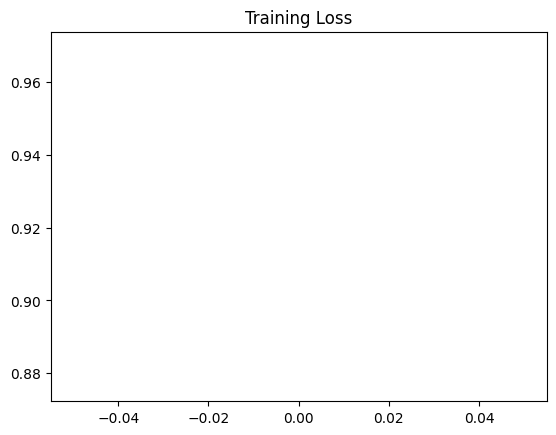

In [14]:
import matplotlib.pyplot as plt
plt.title('Training Loss') 
losses = [np.mean(list(trn_history[i].meters['loss'].deque)) for i in range(len(trn_history))]
plt.plot(losses)

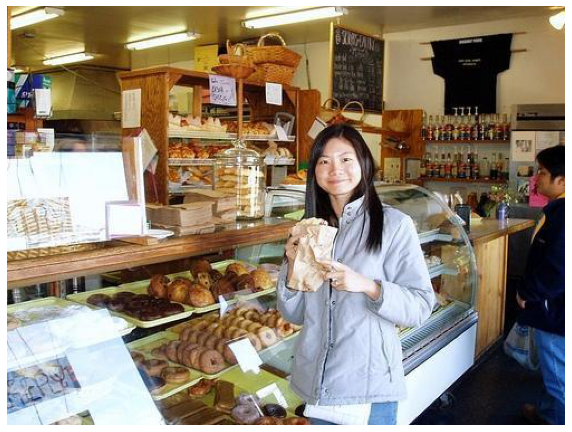

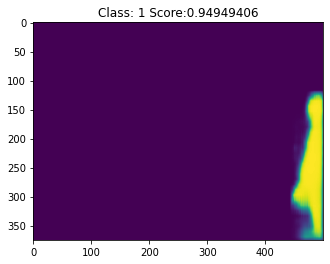

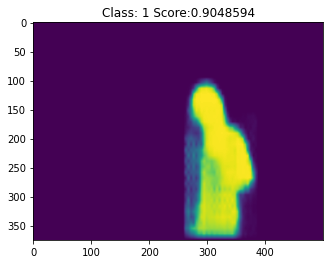

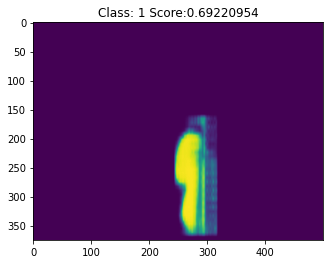

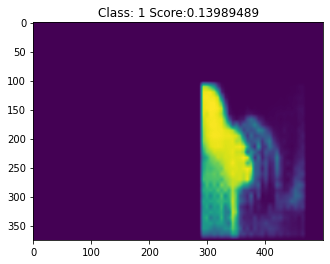

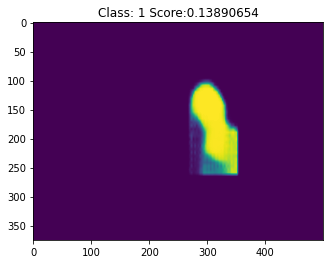

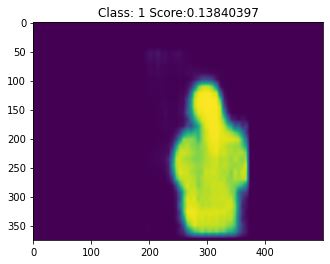

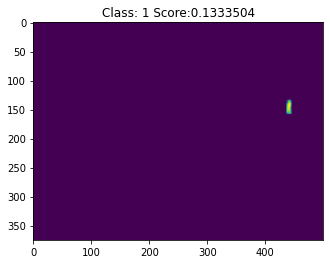

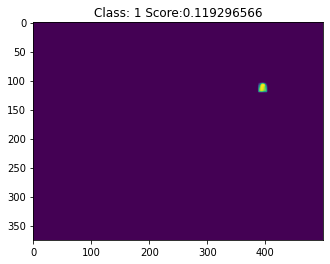

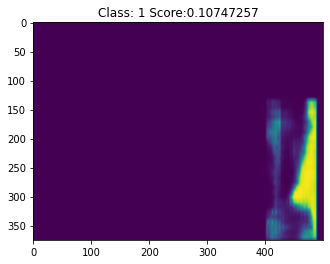

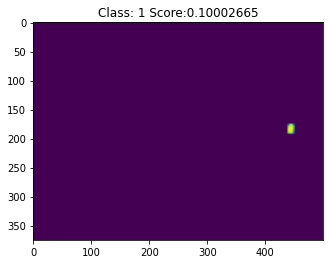

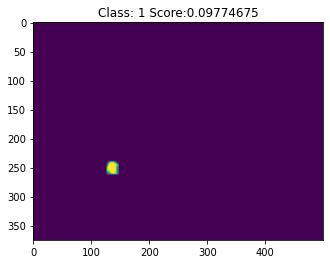

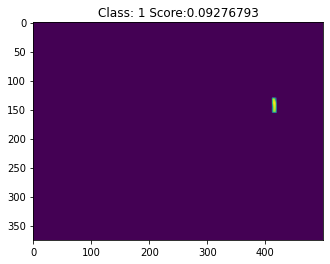

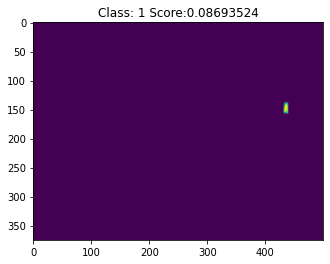

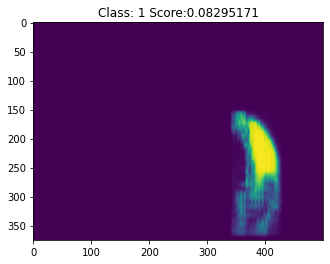

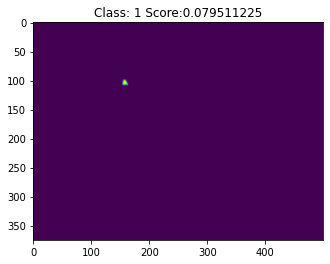

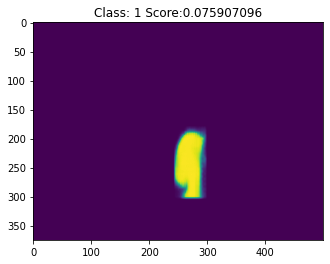

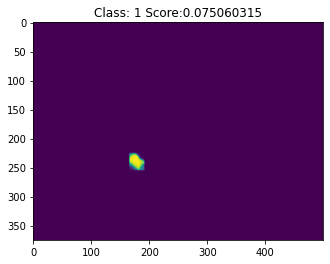

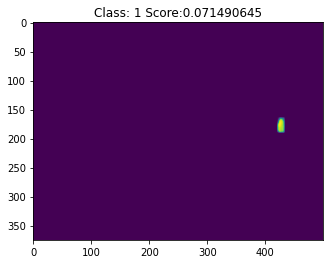

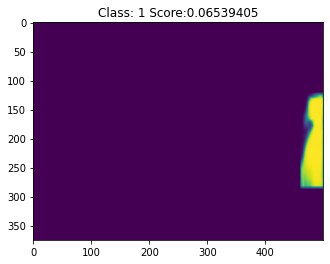

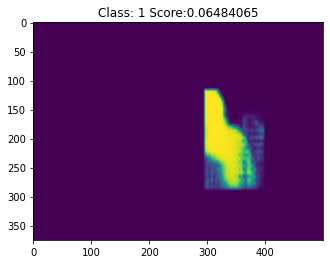

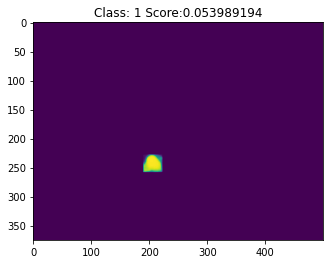

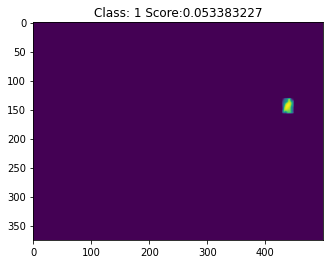

In [ ]:
model.eval()
im = dataset_test[10][0]
show(im)
with torch.no_grad():
    prediction = model([im.to(device)])
    for i in range(len(prediction[0]['masks'])):
        plt.imshow(Image.fromarray(prediction[0]['masks'][i, 0].mul(255).byte().cpu().numpy()))
        plt.title('Class: '+str(prediction[0]['labels'][i].cpu().numpy())+' Score:'+str(prediction[0]['scores'][i].cpu().numpy()))
        plt.show()